In [ ]:
# !pip install jedi==0.10.2

In [ ]:
!pip install setuptools==64.0.2
!apt-get install swig
!pip install wrds
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 23 not upgraded.
Need to get 1,086 kB of archives.
After this operation, 5,41

In [ ]:

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [ ]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [ ]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-06-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.308904,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,36.228397,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.732112,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850744,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.820396,15308300,CAT,2


In [ ]:
df.sample(10)

,date,open,high,low,close,volume,tic,day
72426,2019-03-05,53.849998,53.990002,53.110001,48.213264,21057700,INTC,1
33025,2013-10-08,84.000000,84.169998,82.930000,67.019775,1838900,TRV,1
22247,2012-04-17,107.900002,109.199997,106.720001,80.348991,5321000,CAT,1
37145,2014-05-02,51.435001,51.775002,51.000000,48.120354,10908800,V,4
37022,2014-04-28,137.429993,138.350006,135.970001,105.630836,2244300,MMM,0
26090,2012-10-23,44.074429,44.398853,43.769085,31.581211,13104402,MRK,1
90129,2021-07-07,56.349998,56.580002,56.209999,51.567986,14393300,VZ,2
11094,2010-10-06,29.815001,29.905001,29.680000,20.493362,14123400,KO,2
647,2009-05-04,127.510002,134.429993,126.160004,108.441963,23434000,GS,0
54424,2016-09-13,56.500000,56.650002,56.049999,51.723015,30130200,MSFT,1


In [ ]:
df.shape

(96942, 8)

In [ ]:
df.sort_values(['date','tic']).head(20)

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.308904,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,36.228397,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.732112,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850744,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.820396,15308300,CAT,2
5,2009-04-01,7.815000,8.225000,7.500000,8.172500,13760000,CRM,2
6,2009-04-01,16.510000,17.540001,16.299999,12.300586,73415300,CSCO,2
7,2009-04-01,66.000000,68.699997,65.830002,39.691959,14299000,CVX,2
8,2009-04-01,17.920000,18.820000,17.840000,16.180061,12933600,DIS,2
9,2009-04-01,104.099998,111.339996,103.940002,89.147751,24883000,GS,2


In [ ]:
len(df.tic.unique())

30

In [ ]:
df.tic.value_counts()

AAPL    3315
AMGN    3315
WMT     3315
WBA     3315
VZ      3315
V       3315
UNH     3315
TRV     3315
PG      3315
NKE     3315
MSFT    3315
MRK     3315
MMM     3315
MCD     3315
KO      3315
JPM     3315
JNJ     3315
INTC    3315
IBM     3315
HON     3315
HD      3315
GS      3315
DIS     3315
CVX     3315
CSCO    3315
CRM     3315
CAT     3315
BA      3315
AXP     3315
DOW      807
Name: tic, dtype: int64

### Preprocess Data

In [ ]:
INDICATORS = ['macd','rsi_30', 'cci_30','dx_30']

In [ ]:
fe = FeatureEngineer(use_technical_indicator=True, tech_indicator_list = INDICATORS,
                     use_turbulence=True, user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
89897,2021-07-23,55.830002,56.029999,55.639999,51.547703,14894300,VZ,4,-0.030856,52.164058,50.933161,48.207842,-87.942038,22.778530,51.576051,52.040144,30.778907
50509,2016-03-02,52.410000,52.959999,52.160000,47.812931,29289900,MSFT,2,0.060704,48.474817,43.860370,52.607258,76.306273,0.135589,46.426104,47.626884,18.106667
82032,2020-06-25,197.800003,200.610001,195.470001,195.842926,27803900,MSFT,3,4.846942,199.303109,174.548293,60.055319,127.515189,22.709235,184.168881,176.307506,22.285895
80963,2020-05-04,284.489990,287.940002,282.109985,276.627869,2894200,UNH,0,8.521609,296.119458,240.463869,53.502977,67.404762,17.766145,254.378819,257.443263,29.753808
35372,2014-02-04,35.480000,35.619999,35.169998,31.988108,7004200,NKE,1,-0.673286,35.487285,31.598347,38.329350,-136.902135,35.243462,34.150277,34.763634,39.777348


### Design Environment

In [ ]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

The code is creating an instance of a class "DRLEnsembleAgent", which is  a custom class designed for reinforcement learning in a specific context. The class constructor takes several parameters, which are being passed in as keyword arguments.

The parameters are:

- df: This is a DataFrame containing the data that the agent will use to train and make decisions.
- train_period: A tuple of two dates (or datetime objects) representing the - start and end of the training period.
- val_test_period: A tuple of two dates (or datetime objects) representing the start and end of the validation/testing period.
- rebalance_window: This parameter likely controls how often the agent will adjust its portfolio of investments.
- validation_window : this parameter likely control the data used for validation.
- **env_kwargs : this is a catch-all parameter for any additional keyword arguments that need to be passed to the class constructor.


In [ ]:
rebalance_window = 63 #63 # rebalance_window is the number of days to retrain the model
validation_window = 63 #63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

Following are four dictionaries, each containing specific parameters for three different machine learning models: A2C, PPO, and DDPG.

- A2C_model_kwargs: This is a dictionary that contains the hyperparameters for the A2C(Advantage Actor Critic) model.

- n_steps: It controls the number of steps that the agent takes in the environment before updating the model.
- ent_coef : it is used to control the level of entropy in the policy.
- learning_rate : it is used to control the learning rate of the optimizer.
- PPO_model_kwargs: This is a dictionary that contains the hyperparameters for the PPO(Proximal Policy Optimization) model.

- ent_coef: it controls the level of entropy in the policy.
- n_steps: it controls the number of steps that the agent takes in the environment before updating the model.
- learning_rate: it controls the learning rate of the optimizer.
- batch_size : it controls the number of samples used in one iteration.
- DDPG_model_kwargs: This is a dictionary that contains the hyperparameters for the DDPG(Deep Deterministic Policy Gradient) model.

- learning_rate: it controls the learning rate of the optimizer.
- batch_size: it controls the number of samples used in one iteration.
- timesteps_dict: This is a dictionary that controls the number of timesteps for each model.

- 'a2c': it controls the number of timesteps for A2C model
- 'ppo': it controls the number of timesteps for PPO model
- 'ddpg': it controls the number of timesteps for DDPG model

A2C (Advantage Actor Critic) is a model-based reinforcement learning algorithm that combines the actor-critic method with the concept of the advantage function.

In the actor-critic method, there are two main components: the actor and the critic. The actor is responsible for determining the actions to take in the environment, while the critic is responsible for evaluating the quality of those actions.

The advantage function is a measure of how good a particular action is compared to the average action taken in a given state. It is used to adjust the policy in order to encourage the agent to take actions that lead to better outcomes.

In A2C, the actor and the critic are both neural networks, and are trained together using the same set of data. The actor network is trained to predict the probability distribution of actions given a state, while the critic network is trained to predict the value of a state or the value of a state-action pair.

The A2C algorithm is an on-policy algorithm, which means that it learns from the actions that it takes while interacting with the environment. At each step, the agent selects an action based on its current policy, receives a reward, and updates its policy based on the new information. The agent updates its policy and value function by maximizing the expected return while also maximizing the entropy of the policy to encourage exploration.

A2C is a synchronous variant of the actor-critic algorithm, meaning that both the actor and the critic are updated at the same time after a fixed number of steps, this number of steps is controlled by the 'n_steps' parameter.

A2C can be applied to a wide range of environments, and it is considered as a more sample efficient and stable algorithm compare to other RL algorithm like DDPG and PPO.

In [ ]:
A2C_model_kwargs = {  'n_steps': 5, 'ent_coef': 0.005,'learning_rate': 0.0007 } 

PPO_model_kwargs = {  "ent_coef":0.01, "n_steps": 2, #2048
                    "learning_rate": 0.00025, "batch_size": 128 }

DDPG_model_kwargs = { #"action_noise":"ornstein_uhlenbeck", "buffer_size": 1, #10_000
                      "learning_rate": 0.0005, "batch_size": 64 }

timesteps_dict = {'a2c' : 1, #10_000 each
                  'ppo' : 1,  'ddpg' : 1  }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  203.40446523133815
======Model training from:  2009-04-01 to  2021-01-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
======A2C Validation from:  2021-01-04 to  2021-04-06
A2C Sharpe Ratio:  0.27914720931757303
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_126_1
------------------------------------
| time/              |             |
|    fps             | 40          |
|    iterations      | 1           |
|    time_elapsed    | 0           |
|    total_timesteps | 2           |
| train/             |             |
|    reward          | 0.021304943 |
------------------------------------
======PPO Validation from:  2021-01-04 to  2021-04-06
PPO Sharpe Ratio:  0.29495150295513
======DDPG Training========
{'buf

In [ ]:
df_summary

### Backtest the Strategy

In [ ]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.25363396154432827


In [ ]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2021-04-06,NaN,2021-04-06
1,1.000259e+06,2021-04-07,0.000259,2021-04-07
2,1.000908e+06,2021-04-08,0.000648,2021-04-08
3,1.006320e+06,2021-04-09,0.005407,2021-04-09
4,1.004059e+06,2021-04-12,-0.002246,2021-04-12


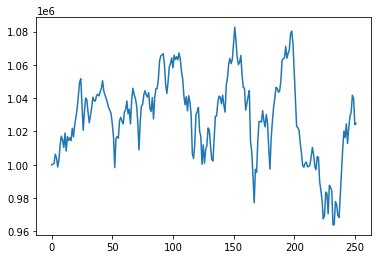

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.024840
Cumulative returns     0.024840
Annual volatility      0.130733
Sharpe ratio           0.253634
Calmar ratio           0.226499
Stability              0.064555
Max drawdown          -0.109670
Omega ratio            1.042003
Sortino ratio          0.354114
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.932197
Daily value at risk   -0.016339
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.037486
Cumulative returns     0.037335
Annual volatility      0.134331
Sharpe ratio           0.342028
Calmar ratio           0.331049
Stability              0.066383
Max drawdown          -0.113235
Omega ratio            1.058031
Sortino ratio          0.480831
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970301
Daily value at risk   -0.016742
dtype: float64


### BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


Start date,2021-04-06
End date,2022-04-01
Total months,12
,Backtest
Annual return,2.484%
Cumulative returns,2.484%
Annual volatility,13.073%
Sharpe ratio,0.25
Calmar ratio,0.23
Stability,0.06
Max drawdown,-10.967%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.97,2021-11-08,2022-03-07,NaT,NaN
1,6.27,2021-09-02,2021-09-30,2021-11-05,47
2,5.07,2021-05-10,2021-06-18,2021-08-10,67
3,2.24,2021-08-16,2021-08-19,2021-09-02,14
4,1.07,2021-04-21,2021-04-22,2021-04-29,7


Stress Events,mean,min,max
New Normal,0.01%,-2.97%,2.06%


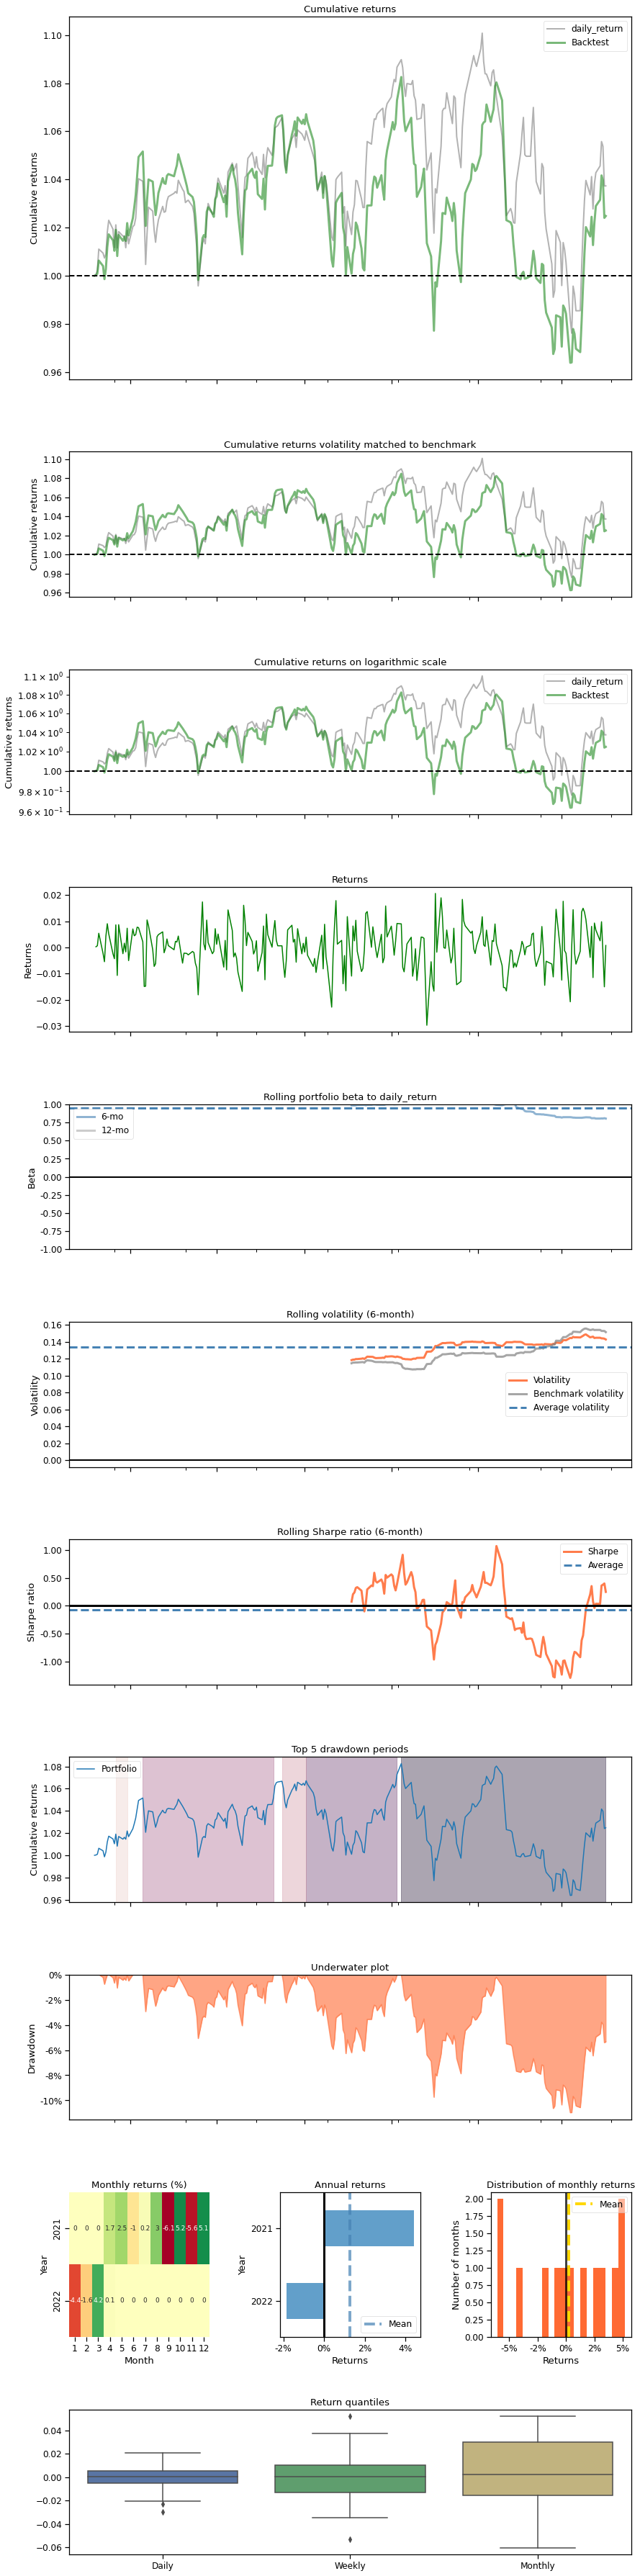

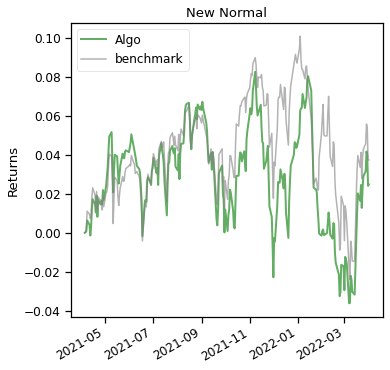

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [ ]:
from flask import Flask, jsonify
import gdown
app = Flask(__name__)

@app.route('/run-colab')
def run_colab():
    gdown.download('https://drive.google.com/file/d/<colab_notebook_id>', 'colab.ipynb', quiet=False)
    return jsonify(message='colab notebook ran successfully')

In [ ]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import datetime as datetime
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import LimitOrderRequest
# #I make a cryptocurrency trading bot and hand it a $1000 dollars and leave it to trade that unsupervised for a week.

# # paper=True enables paper trading
trading_client = TradingClient('AKBX22ZJIYXAAD7YPOB0', 'dfHX3SjDlg85SDtDAVQQqrfPTqD2npPKQj0ifMSf', paper=False)


##Market Order 
# preparing orders
market_order_data = MarketOrderRequest(
                    symbol="NVDA",
                    qty=1,
                    side=OrderSide.SELL,
                    time_in_force=TimeInForce.DAY
                    )

# Market order
market_order = trading_client.submit_order(
                order_data=market_order_data
               )

# if(DRLEnsembleAGent.Sharpe > .4)

# # Market order
# market_order = trading_client.submit_order(fndsdsdsfdsdsf
#                 order_data=market_order_data
#                )

# else
# print(no trades for today)

In [ ]:
!pip install alpaca-py

In [ ]:
!pip install alpaca

In [ ]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import datetime as datetime
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import LimitOrderRequest

# #I make a cryptocurrency trading bot and hand it a $1000 dollars and leave it to trade that unsupervised for a week.

# # paper=True enables paper trading
trading_client = TradingClient('PKJFG13OGRFGBCNGW757', 'xgUhyrffFUxOmuSchcONqHcbFc6kMjMHOWodxwH9', paper=True)


##Market Order 
# preparing orders
market_order_data = MarketOrderRequest(
                    symbol="SPY",
                    qty=10,
                    side=OrderSide.BUY,
                    time_in_force=TimeInForce.DAY
                    )

# Market order
market_order = trading_client.submit_order(
                order_data=market_order_data
               )


## Twitter Sentiment Analysis 

# limit_order_data = LimitOrderRequest(
#                     symbol="BTC/USD",
#                     limit_price=17000,
#                     notional=4000,
#                     side=OrderSide.SELL,
#                     time_in_force=TimeInForce.FOK
#                    )

# # Limit order
# limit_order = trading_client.submit_order(
#                 order_data=limit_order_data
#               )

# wss_client = StockDataStream('AKIQ3ALAC0B2HOM1PPNE', 'dMekSYsqKqyoF6WM4lJ8YnE92ERDxeQVrhvrjAxa')

# # async handler
# async def quote_data_handler(data):
#     # quote data will arrive here
#     print(data)


# wss_client.subscribe_quotes(quote_data_handler, "AAPL")

# wss_client.run()

# # no keys required for crypto data
# client = CryptoHistoricalDataClient()

# request_params = CryptoBarsRequest(
#                         symbol_or_symbols=["BTC/USD", "ETH/USD"],
#                         timeframe=TimeFrame.Day,
#                         start=datetime.datetime(2022, 12, 20, 14, 30)
#                  )

# bars = client.get_crypto_bars(request_params)
# bars.df
# print(bars)


